# Comparing Entity Matching models with SDK-experimental demo

This notebook uses time series and assets from the open industrial data tenant. It uses cognite-sdk-python-experimental to fit entity matcher models using different parameter combinations. The data is split into a training and test set. The models are compared using running time and the F1 score (combination of precision and recall) on the test set. To read the definition of precision and reacll see [here](https://en.wikipedia.org/wiki/Precision_and_recall). 

One model is chosen and the false positives (incorrect predicted matches by the model), and false negatives (matches the model were not able to find) are briefly investigated.

## Get access to CDF
We assume you have some basic knowledge of CDF and the SDK. If not, please follow the 'lab' tutorials first.

For this tutorial you need access to the publicdata project / tenant. If you don't have one, you can get an API-key [here](https://content.cognite.com/open-industrial-data).

## Import modules
We need to import some Python modules in order to interact with CDF. We will use the Python SDK with Experimental Extensions, which we below refer to as a client. 

In [1]:
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from cognite.client.beta import CogniteClient
from getpass import getpass

## Create a client

When you create the CogniteClient below, getpass will ask for your API key in an extra password field. Simply paste ypu publicdata API-key and press shift+enter.

In [2]:
project = "contextualization"
api_key = getpass("Please enter Open Industrial Data API-KEY: ")
client = CogniteClient(project=project, api_key=api_key, client_name="dshub")

Please enter Open Industrial Data API-KEY: ········


## Get data

In this tutorial we will use time series and assets data.

In [3]:
time_series = client.time_series.list(limit=1000)

# Split into train and test data

Shuffle the time-series list randomly and use the first 60% as the training set and the rest as the test set.

In [4]:
train_size = 0.6
num_train_samples = round(len(time_series) * train_size)

In [59]:
random.seed(1006)
random.shuffle(time_series)
time_series_train = time_series[0:num_train_samples]
time_series_test = time_series[num_train_samples:]

true_matches_train = [(x.get("id"), x.get("asset_id")) for x in time_series_train.dump()]
true_matches_test = [(x.get("id"), x.get("asset_id")) for x in time_series_test.dump()]

true_matches_train = [x for x in true_matches_train if x[1]!=None]
true_matches_test = [x for x in true_matches_test if x[1]!=None]

In [60]:
assetsIds=list(set([x[1] for x in true_matches_train]))
assets=client.assets.retrieve_multiple(ids=assetsIds)

## Test different parameter combinations

In this tutorial 10 parameter combinations are tested.

In [76]:
test_combs = [
    {
        "name": "simple",
        "match_fields": [("name", "name")],
        "feature_type": "simple",
        "classifier": "RandomForest",
    },
    {
        "name": "simple_extra_keys",
        "match_fields": [("name", "name"), ("description", "description")],
        "feature_type": "simple",
        "classifier": "RandomForest",
    },
    {
        "name": "bigram",
        "match_fields": [("name", "name")],
        "feature_type": "bigram",
        "classifier": "RandomForest",
    },
    {
        "name": "bigram_extra_keys",
        "match_fields": [("name", "name"), ("description", "description")],
        "feature_type": "bigram",
        "classifier": "RandomForest",
    },
    {
        "name": "simple_all_keys",
        "match_fields": [
            ("name", "name"),
            ("description", "description"),
            ("name", "description"),
            ("description", "name"),
        ],
        "feature_type": "simple",
        "classifier": "RandomForest",
    },
    {
        "name": "frequency_weighted_bigram",
        "match_fields": [("name", "name")],
        "feature_type": "simple",
        "classifier": "RandomForest",
    },
    {
        "name": "frequency_weighted_bigram",
        "match_fields": [("name", "name")],
        "feature_type": "frequency-weighted-bigram",
        "classifier": "RandomForest",
    },
    {
        "name": "bigram_extra_tokenizers",
        "match_fields": [("name", "name")],
        "feature_type": "bigram-extra-tokenizers",
        "classifier": "RandomForest",
    },
    {
        "name": "bigram_combo",
        "match_fields": [("name", "name")],
        "feature_type": "bigram-combo",
        "classifier": "RandomForest",
    },
    {
        "name": "unsupervised",
        "match_fields": [("name", "name")],
        "feature_type": "bigram",
        "classifier": "Unsupervised",
    },
]

In [81]:
def evaluate(true_matches, predicted_matches, score_threshold):
    """ 
    Evaluate the performance of a model. 
    Find true-postives, false-negative and false-positives gien a score threshold.
    Calculate the precision, recall and F1 score.
    """
    predicted_positive_match = [
        x
        for x in predicted_matches
        if x.get("matches") and x["matches"][0]["score"] > score_threshold
    ]
    predicted_positive_matches = [
        (x["source"]["id"], x["matches"][0]["target"]["id"])
        for x in predicted_positive_match
    ]

    # Calculate precision, recall and f1_beta
    true_positives = [x for x in predicted_positive_matches if x in true_matches]
    false_postives = [x for x in predicted_positive_matches if x not in true_matches]
    false_negatives = [x for x in true_matches if x not in predicted_positive_matches]

    precision = len(true_positives) / (len(true_positives) + len(false_postives))
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))

    f1 = 2 * precision * recall / (precision + recall)
    return (true_positives, false_postives, false_negatives, precision, recall, f1)

Loop through all test combinations. Fit a model using the training data and predict time-series to asset matches for the test data. Use the true matches for the test data to evaluate the performance of the model.
Store run time as the time from the model starts training until it is done predicting. 

In [62]:
assets

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id,source,data_set_id
0,SKA_2103084985443500,65-VI-5221,6545389140694605,SKA_1580972305457440,VIBR. PROBE FOR 65-PB-522-M01 (DE),"{'ASSETSCOPENAME': 'SKA', 'ELC_STATUS_ID': '12...",1209990986430470,1574931419384,1574931419384,4468528765940921,NaN,<NA>
1,ALV_06B/10,06B/10,4758843894792907,ALV_06-CABLES,CABLE,"{'AVEVA_status': 'Active', 'Platform': 'ALV', ...",4337506750939154,1574165306338,1574165306338,1242837143139220,ALV,<NA>
2,SKA_3484482042724348,97-GK-503A,3041439621245214,SKA_2970963999089568,CENTRIFUGAL FAN EXTRACT FROM GALLEY,"{'ASSETSCOPENAME': 'SKA', 'ELC_STATUS_ID': '12...",6038045406484507,1574931380793,1574931380793,4468528765940921,NaN,<NA>
3,SKA_102360099375134,39-XV-5115,5750606207902084,SKA_4392077141880216,NO 3 COT (P) CO WASHING HDR ISO PSD VLV,"{'ASSETSCOPENAME': 'SKA', 'ELC_STATUS_ID': '12...",8174571818559521,1574931410165,1574931410165,4468528765940921,NaN,<NA>
4,ALV_70AB10110038,70AB10110038,218286261861503,ALV_11690937,UPPER PROCESS DECK GAS DETECTOR TP30,"{'AVEVA_status': 'Active', 'Platform': 'ALV', ...",8997822500354083,1574165362992,1574165362992,1242837143139220,ALV,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
309,ALV_41XV0111,41XV0111,8422845771065454,ALV_45HA001-03,U/S HEATER 45HA001.,"{'AVEVA_status': 'Active', 'Platform': 'ALV', ...",5285056683268058,1574165271751,1574165271751,1242837143139220,ALV,<NA>
310,ALV_41PT0130,41PT0130,3535248407388189,ALV_41PA001B-03,H.M. CIRC PUMP B INLET PRESS TRANS,"{'AVEVA_status': 'Active', 'Platform': 'ALV', ...",1934573016238057,1574165270611,1574165270611,1242837143139220,ALV,<NA>
311,SKA_7935528400704177,70-AB-0131-030,7594902862099413,SKA_5147283141001056,GAS POINT P200 TOP DECK STBD SIDE,"{'ASSETSCOPENAME': 'SKA', 'ELC_STATUS_ID': '12...",8818375360278513,1574931424562,1574931424562,4468528765940921,NaN,<NA>
312,SKA_2907430145799003,13-BSV-0013,2317940267806756,SKA_4832572198021063,TO FLARE,"{'ASSETSCOPENAME': 'SKA', 'ELC_STATUS_ID': '12...",4322580358623221,1574931407968,1574931407968,4468528765940921,NaN,<NA>


In [77]:
test_combs[0:1]

[{'name': 'simple',
  'match_fields': [('name', 'name')],
  'feature_type': 'simple',
  'classifier': 'RandomForest'}]

In [82]:
score_threshold = 0.75
for parameter_comb in test_combs:
    if parameter_comb["classifier"] == "Unsupervised":
        true_matches = None
        classifier = None
    else:
        true_matches = true_matches_train
        classifier = parameter_comb["classifier"]

    start_time = time.time()
    model = client.entity_matching.fit(
        sources=time_series_train,
        targets=assets,
        true_matches=true_matches,
        match_fields=parameter_comb["match_fields"],
        feature_type=parameter_comb["feature_type"],
        classifier=classifier,
        ignore_missing_fields=True,
        name=parameter_comb["name"],
    )
    
    results = model.predict(
        sources=time_series_test, targets=assets).result
    parameter_comb["runtime"] = time.time() - start_time
    (tp, fp, fn, precision, recall, f1) = evaluate(
        true_matches=true_matches_test,
        predicted_matches=results["items"],
        score_threshold=score_threshold,
    )
    parameter_comb["precision"], parameter_comb["recall"], parameter_comb["f1"] = (
        precision,
        recall,
        f1,
    )
    parameter_comb["id"] = model.id


## Plot the results

In [83]:
x = [test_comb["f1"] for test_comb in test_combs]
y = [test_comb["runtime"] for test_comb in test_combs]
labels = [test_comb["name"] for test_comb in test_combs]

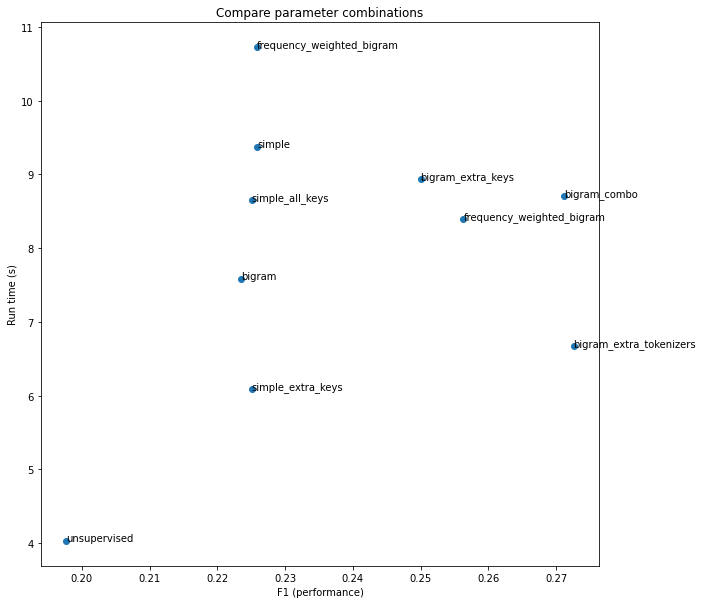

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y)

ax.set_ylabel("Run time (s)")
ax.set_xlabel("F1 (performance)")
ax.set_title("Compare parameter combinations")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

## Select a model, retrieve and update it and investigate the results

In [85]:
# Select model by name
id_selected = [
    x["id"] for x in test_combs if x["name"] == "bigram_extra_tokenizers"
][0]

In [86]:
# Retrive the model
model = client.entity_matching.retrieve(id=id_selected)
model

,value
id,6916363549793125
status,Completed
created_time,1607427184579
start_time,1607427185038
status_time,1607427185740
classifier,RandomForest
feature_type,bigram-extra-tokenizers
match_fields,"[{'source': 'name', 'target': 'name'}]"
name,bigram_extra_tokenizers


### Update the description of the model
Updating the model is not yet available in the SDK. It will soon be, but for now we have to use the API.

In [87]:
model.description = "My chosen model"
model = client.entity_matching.update(model)

### Investigate the results

In [89]:
# Predict on the test-data and evaluate ones more.
results = model.predict(sources=time_series_test, targets=assets).result
(tp, fp, fn, precision, recall, f1) = evaluate(
    true_matches=true_matches_test,
    predicted_matches=results["items"],
    score_threshold=score_threshold,
)

#### Predicted matches

In [95]:
predicted_matches_list = []
for x in results["items"]:
    time_series_id = x["source"]["id"]
    time_series_name = x["source"]["name"]
    matches = x["matches"]
    if matches:
        score = matches[0]["score"]
        asset_name = matches[0]["target"]["name"]
    else:
        score, asset_name = "", ""
    predicted_matches_list.append(
        {
            "time_series_id": time_series_id,
            "time_series_name": time_series_name,
            "predicted_asset_name": asset_name,
            "score": score,
        }
    )
df_predicted_matches = pd.DataFrame(predicted_matches_list)
df_predicted_matches.head()

,time_series_id,time_series_name,predicted_asset_name,score
0,25727499434414,SKAP_80GP200Reg/Y/PRIM,80-VI-4241Y,0.939237
1,38139055347597,SKAP_42XV0001/BCH/PRIM,42-XV-0002,0.391626
2,97333736582180,vtt_ska_vos_43XY1001,SKA,0.0274027
3,82723390997986,OS07 Net A-Bow Orion,Bow Orion,0.981156
4,14550808011636,vtt_ska_rto_97BV5787,97-BV-5741,0.501182


#### False negatives

In [96]:
df_time_series = time_series_test.to_pandas()[["id", "name", "assetId"]].add_prefix(
    "time_series_"
)
df_assets = assets.to_pandas()[["id", "name"]]

false_negatives = pd.merge(
    pd.DataFrame(fn), df_time_series, how="left", left_on=0, right_on="time_series_id"
)
false_negatives = pd.merge(
    false_negatives,
    df_assets.add_prefix("asset_"),
    how="left",
    left_on=1,
    right_on="asset_id",
)
false_negatives = pd.merge(false_negatives, df_predicted_matches, how="left")
false_negatives.drop(
    [0, 1, "time_series_id", "time_series_assetId", "asset_id"], axis=1, inplace=True
)
false_negatives.head()

,time_series_name,asset_name,predicted_asset_name,score
0,SKAP_80GP200Reg/Y/PRIM,SKA,80-VI-4241Y,0.939237
1,SKAP_42XV0001/BCH/PRIM,NaN,42-XV-0002,0.391626
2,vtt_ska_vos_43XY1001,NaN,SKA,0.0274027
3,vtt_ska_rto_97BV5787,NaN,97-BV-5741,0.501182
4,SKAP_50FSI0125/pAlLimHH/30sSAMP,NaN,50-FSI-0120,0.391626


## Delete all created models

In [97]:
id_list = [x["id"] for x in test_combs]
client.entity_matching.delete(id_list)